## **Fake News Detection**

# Model Training

Import Library

In [34]:
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
import pandas as pd
import seaborn as sb
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Load dataset
# df_fake = pd.read_csv("../data/fake.csv")  # Update path as needed

# df_fake.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Import Data

In [35]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "fake.csv"

# Load the latest version
df_fake = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "bhavikjikadara/fake-news-detection",
  file_path,
)

df_fake.head(10)

<ipython-input-35-7d368832c431>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_fake = kagglehub.load_dataset(


100%|██████████| 22.9M/22.9M [00:00<00:00, 65.2MB/s]

Extracting zip of fake.csv...


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [36]:
file_path = "true.csv"
# Load the latest version
df_real = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "bhavikjikadara/fake-news-detection",
  file_path,
)

<ipython-input-36-67809a6765df>:3: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_real = kagglehub.load_dataset(


100%|██████████| 18.1M/18.1M [00:00<00:00, 36.7MB/s]

Extracting zip of true.csv...


In [37]:
df_fake['Label'] = 'False'
df_real['Label'] = 'True'
df = pd.concat([df_fake,df_real])
df.head()

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",False
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",False
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",False
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",False
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",False


In [38]:
print(f'Data rows: {df.shape[0]}, Data columns: {df.shape[1]}')

Data rows: 44898, Data columns: 5


In [39]:
df.isna().sum()


,0
title,0
text,0
subject,0
date,0
Label,0


In [40]:
df.duplicated().sum()

np.int64(209)

In [41]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print(f'Data rows after cleaning: {df.shape[0]}, Data columns after cleaning: {df.shape[1]}')

Data rows after cleaning: 44689, Data columns after cleaning: 5


In [42]:
df = df.rename(columns={"text": "Statement"})

In [43]:
df = df.rename(columns={"label": "Label"})

In [44]:
df = df.sample(frac = 1)

In [45]:
df.head()

,title,Statement,subject,date,Label
9266,SARA CARTER Drops Shocker On Why A Shake-Up Is...,Sara Carter has been right on everything she s...,politics,"Dec 5, 2017",False
3957,WATCH: Fox Anchor Forced To Admit He Lied Abo...,You know all that buzz you are hearing about a...,News,"November 3, 2016",False
14846,SHE SHOULD NEVER HAVE BEEN ALLOWED To Step Foo...,CAN WE JUST STOP ALLOWING Muslim Refugees and ...,politics,"Dec 4, 2015",False
712,Scientists decry Arctic oil expansion in lette...,NEW YORK (Reuters) - A group of 37 U.S.-based ...,politicsNews,"November 9, 2017",True
752,Breaking: Secretary Of State Debates Abandoni...,Donald Trump s horrible decisions and disgusti...,News,"July 24, 2017",False


In [46]:
import string
def clean_text(text):
    # Converting all text to lowercase
    text = text.lower()

    # Delete link/URL
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Delete emoji and characters non-ASCII
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Normalize Words
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "i am", text)
    text = re.sub(r"dont", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    # Remove punctuation and other symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Delete numbers
    text = re.sub(r'\d+', ' ', text)

    # Removing double spaces that may form
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub('\w*\d\w*','',text)
    return text
df['Statement'] = df['Statement'].apply(clean_text)

# Example usage
sample_text = "Breaking News! Fake news spreads quickly on social media."
print(clean_text(sample_text))

breaking news fake news spreads quickly on social media


In [47]:
df.sample(5)

,title,Statement,subject,date,Label
18677,Israeli nuclear whistleblower gets offer to li...,oslo reuters norway offered on friday to let i...,worldnews,"September 29, 2017",True
796,Story Withdrawn: Wealthy win in U.S. House tax...,washington reuters please note that the story ...,politicsNews,"November 6, 2017",True
13300,DONALD TRUMP’S COMEBACK After 50 RINO “Republi...,so called republicans just outed themselves an...,politics,"Aug 9, 2016",False
7138,Fact Checkers Clear Hillary Of ‘Big Oil Bribes’,among the slew of baseless attacks launched ag...,News,"April 2, 2016",False
7786,\r\r\r\r\r\r\r\nDonald Trump Gets His A** Hand...,a year old girl smacked down donald trump and ...,News,"February 29, 2016",False


In [48]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = text.split()
    processed_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(processed_words)

df['Statement'] = df['Statement'].apply(preprocess_text)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 9266 to 15134
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44689 non-null  object
 1   Statement  44689 non-null  object
 2   subject    44689 non-null  object
 3   date       44689 non-null  object
 4   Label      44689 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [50]:
df = df[['Statement', 'Label']]
df.head()

,Statement,Label
9266,sara carter right everyth report mueller inves...,False
3957,know buzz hear like hillari clinton fbi indict...,False
14846,stop allow musli refuge visitor u countri hate...,False
712,new york reuter group u base scientist whose r...,True
752,donald trump horribl decis disgust behavior ma...,False


<ipython-input-236-9bf9efb7e872>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  return sb.countplot(x='Label', data=dataFile, palette='hls')


<Axes: xlabel='Label', ylabel='count'>

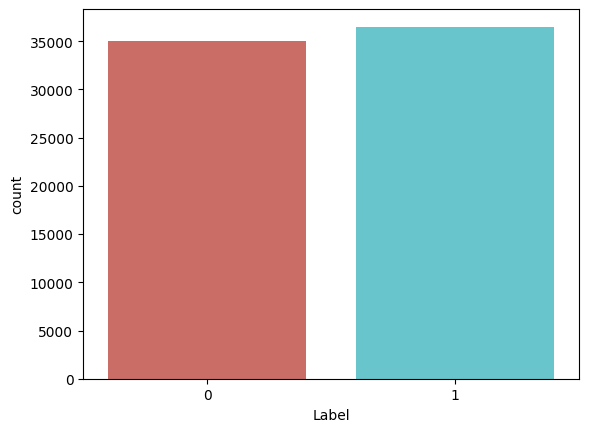

In [236]:
def create_distribution(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(df)

In [237]:
def data_qualityCheck():
    print("Checking data qualitites...")
    df.isnull().sum()
    df.info()
    print("check finished.")
data_qualityCheck()

df = df.dropna()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
Index: 71537 entries, 53609 to 57953
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  71537 non-null  object
 1   Label      71537 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
check finished.


In [51]:
print(df.columns)
df.shape
print(df.columns)

Index(['Statement', 'Label'], dtype='object')
Index(['Statement', 'Label'], dtype='object')


In [239]:
print(df.columns)
df.reset_index(drop= True,inplace=True)
df.head(10)

Index(['Statement', 'Label'], dtype='object')


,Statement,Label
0,mexico citi sinc novemb mexican author eager c...,0
1,former presid bill clinton much frequent flyer...,0
2,former new york citi mayor michael bloomberg t...,0
3,tokyo reuter presid donald trump japanes pri a...,0
4,new year mani us mean probabl made resolut kno...,1
5,speak evangel phd slam religi right leader sup...,1
6,manila reuter philippin environ minist said ho...,0
7,twitterg happen right twitter pedophil account...,1
8,failur democraci oligarch plan steal elect pau...,1
9,harar reuter zi ambabw presid emmerson mnangag...,0


In [52]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df.Label = label_encoder.fit_transform(df.Label)

In [241]:
Label_train = df.Label


In [242]:
Label_train.head(10)


,Label
0,0
1,0
2,0
3,0
4,1
5,1
6,0
7,1
8,1
9,0


In [243]:
# df.drop('Label', axis=1, inplace=True)

In [53]:
df.head(10)

,Statement,Label
9266,sara carter right everyth report mueller inves...,0
3957,know buzz hear like hillari clinton fbi indict...,0
14846,stop allow musli refuge visitor u countri hate...,0
712,new york reuter group u base scientist whose r...,1
752,donald trump horribl decis disgust behavior ma...,0
10531,tennesse lawmak someth say counterpart califor...,0
9026,donald trump wrote book think would come back ...,0
20641,ankara reuter turkish court order releas parli...,1
15147,london thomson reuter foundat self design home...,1
2733,accord white supremacist dirtbag former head h...,0


In [245]:
df['Statement'][2188]

'trap messag trump campaign decid go ask trump respons father musli man die serv american armi captain oversea narr trump campaign use often trump say someth horribl camera media twist word one trump surrog scotti nell hugh tri use tactic segment cnn new day sunday morn father khizr khan spoke democrat nation convent call trump propos ban musli am enter unit state khan said speech trump sacrif noth one life trump billionair respond say think made lot sacrific work hard creat thousand thousand job ten thousand job built great structur tremend success think done lot respons came interview georg stephanopoulo hugh say initi disappoint trump comment khan howev realiz interview part media agenda make trump look bad appar someth could never mind trump support tell peopl truth giant media conspiraci read question trump campaign other releas full transcript see setup noth trap mr trump go forward truth trump trap trap vile rhetor spew throughout pri amari elect went full fascist prevent hi abl

In [246]:
Label_train

,Label
0,0
1,0
2,0
3,0
4,1
...,...
71532,1
71533,1
71534,0
71535,1


In [247]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [248]:
stpwrds

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [249]:
print(df.columns)

Index(['Statement', 'Label'], dtype='object')


In [54]:
for x in range(len(df)) :
    corpus = []
    review = df['Statement'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    df.loc[x,'Statement'] = review

TypeError: expected string or bytes-like object, got 'Series'

In [251]:
Statement_train = df.Statement

In [252]:
Statement_train.head()

,Statement
0,mexico citi sinc novemb mexican author eager c...
1,former presid bill clinton much frequent flyer...
2,former new york citi mayor michael bloomberg t...
3,tokyo reuter presid donald trump japanes pri a...
4,new year mani u mean probabl made resolut know...


In [253]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(Statement_train, Label_train, test_size=0.4, random_state=42)

In [254]:
X_train.shape, y_train.shape

((42922,), (42922,))

In [255]:
X_train

,Statement
48726,iran use billion cash resourc provid landmark ...
53522,hard know obama hate america israel polic offi...
58584,havana reuter jill biden wife u vice presid jo...
16233,beirut reuter syrian armi alli forc come withi...
43127,abidjan reuter three unit nation soldier bangl...
...,...
37194,pari reuter venezuela govern opposit hold roun...
6265,milan reuter itali fincantieri franc naval gro...
54886,maintain human perpetu balanc natur georgia gu...
860,came close iowa fell short clai ame victori tu...


In [256]:
y_train

,Label
48726,1
53522,1
58584,0
16233,0
43127,0
...,...
37194,0
6265,0
54886,1
860,0


In [ ]:
X_test

In [ ]:
X_test.shape, y_test.shape

In [ ]:
# Preprocessing
vectorizer = TfidfVectorizer(stop_words='english',max_features=5000)
vec_X_train = vectorizer.fit_transform(X_train)
vec_X_test = vectorizer.transform(X_test)

# Save the trained vectorizer
# with open("../models/tfidf_vectorizer2.pkl", "wb") as file:
#     pickle.dump(vectorizer, file)

In [ ]:
vec_X_train.shape, vec_X_test.shape

In [ ]:
import itertools

import numpy as np


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [ ]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Step 1: Base models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=0, n_estimators=100),
    "GradientBoosting": GradientBoostingClassifier(random_state=0),
    "PassiveAggressive": PassiveAggressiveClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Step 2: Add SVMs with different C values
svm_c_values = [0.1, 1, 10]
for c in svm_c_values:
    models[f"SVM (C={c})"] = SVC(kernel='linear', C=c)


In [99]:
import numpy as np
from sklearn import metrics

accuracies = {}
for name, model in models.items():
    model.fit(vec_X_train, y_train)
    y_pred = model.predict(vec_X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f'{name} Accuracy: {round(acc*100,2)}%')

    # Save model
    # with open(f"../models/{name.replace(' ', '_').lower()}.pkl", "wb") as f:
    #     pickle.dump(model, f)

Naive Bayes Accuracy: 83.38%
Logistic Regression Accuracy: 92.85%
Random Forest Accuracy: 92.82%
GradientBoosting Accuracy: 91.48%
PassiveAggressive Accuracy: 92.4%


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:58:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 94.85%


KeyboardInterrupt: 

In [ ]:
# Plot improved accuracy comparison graph
plt.figure(figsize=(10,5))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange'])

# Adding value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{round(yval*100,2)}", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.ylim(0.8, 1)  # Accuracy y-axis ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=1)

plt.show()


# Model Testing

In [ ]:
print(models)

In [ ]:
import pandas as pd

def output_label(n):
    return "Fake News" if n == 0 else "Not A Fake News"

def manual_testing(news):
    # Ensure 'models' contains trained models
    for name, model in models.items():  # FIXED: Use `models.items()` instead of `models()`

        # Create a DataFrame for input news
        testing_news = {"text": [news]}
        new_def_test = pd.DataFrame(testing_news)

        # Apply text preprocessing (Ensure 'clean_text' is defined)
        new_def_test['text'] = new_def_test["text"].apply(clean_text)

        # Transform input using the loaded vectorizer
        new_xv_test = vectorizer.transform(new_def_test["text"])

        # Get model predictions
        test_pred = model.predict(new_xv_test)

        # Print prediction correctly
        print(f"{name} Prediction: {output_label(test_pred[0])}")  # FIXED: Index test_pred

In [ ]:
news ="Federal health officials told the AP they have not received any reports of Ebola cases at the Nevada event. A screenshot of a supposed post from the Centers for Disease Control and Prevention confirming such cases was fabricated. And there is no record of a national emergency being declared. The claims emerged after summer storm left muddy roads flooded, stranding tens of thousands of partygoers; event organizers let traffic flow out of the main road Monday afternoon. “So it was announced earlier that Burning Man was declared a national emergency because it was flooded, and so they sent in FEMA,” a woman claims in a TikTok video shared on Instagram, suggesting the development was suspicious. The AP found no record, including on federal websites and in White House announcements, of a national emergency declaration and FEMA confirmed that it was not involved in the situation. “No FEMA personnel or assets have been deployed to the Burning Man festival and there are no requests from local or state authorities for our assistance,” FEMA spokesperson Jeremy Edwards said in an email. The TikTok video, like other posts, goes on to relay baseless rumors of reported cases of Ebola, whose occasional outbreaks in humans primarily occur in Africa, at the festival. Some posts also shared an image made to appear that the CDC confirmed the supposed outbreak on X, the platform formerly known as Twitter. The purported X post from the agency reads, “Ebola outbreak confirmed at Black Rock City, NV. It is recommended that all Burning Man attendees remain in their dwellings until further notice. Current State of Emergency in progress.” But the CDC’s X account published no such post. “CDC has not received any reports of Ebola at the Burning Man Festival and has not issued any warnings or had any requests for assistance from the state and local health departments either,” agency spokesperson Scott Pauley said in an email. Reverse image searches further show that a graphic about Ebola used in the fictitious CDC post was published by the agency in 2016, but elements of it were changed. For example, the original graphic asks, “Recently in West Africa?” But the version used in the made-up X post asks, “Recently in Nevada?” Referencing more online rumors, Pauley also noted the CDC had not received reports of mpox, formerly known as monkeypox, or Marburg, a rare but severe hemorrhagic fever, in relation to Burning Man. A representative for the Burning Man Project organization also refuted the online claims. “Quite simply, the online rumors of transmissible illnesses in Black Rock City are unfounded and untrue,” Dominique Debucquoy-Dodley said in an email. The festival had been closed to vehicles after more than a half-inch (1.3 centimeters) of rain fell Sept. 1, causing flooding and foot-deep mud, as the AP reported. The annual gathering, which launched on a San Francisco beach in 1986, attracts nearly 80,000 artists, musicians and activists for a mix of wilderness camping and avant-garde performances"
manual_testing(news)

In [ ]:
news = "MOSCOW (Reuters) - Russiaâ€™s former ambassador to Washington, Sergei Kislyak, said on Saturday his conversations with former White House national security adviser Michael Flynn had been transparent and focused on matters of U.S.-Russia cooperation. Kislyak ended his tenure in Washington in July but remains a key figure in ongoing U.S. investigations into Moscowâ€™s alleged meddling in the 2016 presidential election. Flynn was forced to resign in February after it became known that he had failed to disclose the content of conversations he had with Kislyak and misled U.S. Vice-President Mike Pence about their meetings. â€œWe only spoke about the most simple things ... but the communication was completely correct, calm, absolutely transparent. In any case, there were no secrets on our side,â€ Kislyak said during a panel discussion on Russian television. â€œThere are a number of issues which are important for cooperation between Russia and the United States - most of all, terrorism. And that was one of the things we discussed.â€"
manual_testing(news)